In [1]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
WANDB_TOKEN = user_secrets.get_secret("WANDB_TOKEN")

In [2]:
import huggingface_hub

try:
    # login(token=HF_TOKEN)
    huggingface_hub.login(token=HF_TOKEN)
    print("✅ Logged in to Hugging Face Hub")
except Exception as e:
    print(f"❌ Error during login: {e}")
    print("✅ Please ensure you have a valid Hugging Face token in your .env file.")
    exit(1)

✅ Logged in to Hugging Face Hub


In [3]:
import torch
from transformers import AutoModel, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

# Load models
BASE_MODEL_NAME = "Qwen/Qwen2.5-0.5B"
FT_MODEL_NAME = "rtweera/Qwen2.5-0.5B_2025-04-18_11-44-30"
base_model = AutoModel.from_pretrained(BASE_MODEL_NAME)
cls_model = AutoModelForSequenceClassification.from_pretrained(FT_MODEL_NAME)


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

2025-04-20 14:47:46.541168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745160466.783658      69 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745160466.853426      69 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

In [4]:
def get_model_info(model):
    model_info = {}
    # List all layers and their parameters
    layers_info = []
    for name, module in model.named_modules():  # Get all modules (i.e. layers in pytorch terminology) in the network: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
        layers_info.append({
            "Layer Name": name,
            "Layer Type": type(module).__name__,
            # module.parameters() returns an iterator over module parameters, which are the weights and biases of the layer (i.e. tensor). https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter
            # p.numel() returns the total number of elements in the tensor (i.e. the number of parameters in the layer). https://pytorch.org/docs/stable/generated/torch.numel.html#torch.numel
            "Number of Parameters": sum(p.numel() for p in module.parameters()),
            "Trainable Parameters": sum(p.numel() for p in module.parameters() if p.requires_grad),
        })

    model_info["Layers"] = layers_info
    return model_info

In [10]:
# Get model information
model_info = get_model_info(base_model)

print("\nLayers:")
for layer in model_info["Layers"]:
    print(f"  - {layer['Layer Name']} ({layer['Layer Type']}): {layer['Number of Parameters']:,} params")


Layers:
  -  (Qwen2Model): 494,032,768 params
  - embed_tokens (Embedding): 136,134,656 params
  - layers (ModuleList): 357,897,216 params
  - layers.0 (Qwen2DecoderLayer): 14,912,384 params
  - layers.0.self_attn (Qwen2Attention): 1,836,160 params
  - layers.0.self_attn.q_proj (Linear): 803,712 params
  - layers.0.self_attn.k_proj (Linear): 114,816 params
  - layers.0.self_attn.v_proj (Linear): 114,816 params
  - layers.0.self_attn.o_proj (Linear): 802,816 params
  - layers.0.mlp (Qwen2MLP): 13,074,432 params
  - layers.0.mlp.gate_proj (Linear): 4,358,144 params
  - layers.0.mlp.up_proj (Linear): 4,358,144 params
  - layers.0.mlp.down_proj (Linear): 4,358,144 params
  - layers.0.mlp.act_fn (SiLU): 0 params
  - layers.0.input_layernorm (Qwen2RMSNorm): 896 params
  - layers.0.post_attention_layernorm (Qwen2RMSNorm): 896 params
  - layers.1 (Qwen2DecoderLayer): 14,912,384 params
  - layers.1.self_attn (Qwen2Attention): 1,836,160 params
  - layers.1.self_attn.q_proj (Linear): 803,712 par

In [11]:
# Get model information
model_info = get_model_info(cls_model)

print("\nLayers:")
for layer in model_info["Layers"]:
    print(f"  - {layer['Layer Name']} ({layer['Layer Type']}): {layer['Number of Parameters']:,} params")


Layers:
  -  (Qwen2ForSequenceClassification): 493,792,640 params
  - model (Qwen2Model): 493,789,952 params
  - model.embed_tokens (Embedding): 135,891,840 params
  - model.layers (ModuleList): 357,897,216 params
  - model.layers.0 (Qwen2DecoderLayer): 14,912,384 params
  - model.layers.0.self_attn (Qwen2Attention): 1,836,160 params
  - model.layers.0.self_attn.q_proj (Linear): 803,712 params
  - model.layers.0.self_attn.k_proj (Linear): 114,816 params
  - model.layers.0.self_attn.v_proj (Linear): 114,816 params
  - model.layers.0.self_attn.o_proj (Linear): 802,816 params
  - model.layers.0.mlp (Qwen2MLP): 13,074,432 params
  - model.layers.0.mlp.gate_proj (Linear): 4,358,144 params
  - model.layers.0.mlp.up_proj (Linear): 4,358,144 params
  - model.layers.0.mlp.down_proj (Linear): 4,358,144 params
  - model.layers.0.mlp.act_fn (SiLU): 0 params
  - model.layers.0.input_layernorm (Qwen2RMSNorm): 896 params
  - model.layers.0.post_attention_layernorm (Qwen2RMSNorm): 896 params
  - mode

In [5]:
base_state = base_model.state_dict()
cls_state = cls_model.state_dict()

In [6]:
base_state

OrderedDict([('embed_tokens.weight',
              tensor([[-1.0071e-02,  4.1992e-02,  9.8877e-03,  ...,  9.9487e-03,
                        1.5137e-02, -7.0496e-03],
                      [-1.4648e-02,  6.0320e-05, -1.8433e-02,  ..., -1.6937e-03,
                        3.1128e-03, -8.4229e-03],
                      [-3.6621e-02, -9.8267e-03,  6.9885e-03,  ..., -7.7515e-03,
                       -1.7090e-02, -1.0490e-04],
                      ...,
                      [ 2.7771e-03, -9.3994e-03,  4.2419e-03,  ..., -6.5613e-03,
                       -1.0620e-02,  1.7212e-02],
                      [ 2.7771e-03, -9.3994e-03,  4.2419e-03,  ..., -6.5613e-03,
                       -1.0620e-02,  1.7212e-02],
                      [ 2.7771e-03, -9.3994e-03,  4.2419e-03,  ..., -6.5613e-03,
                       -1.0620e-02,  1.7212e-02]])),
             ('layers.0.self_attn.q_proj.weight',
              tensor([[ 0.0025, -0.0002,  0.0155,  ..., -0.0005, -0.0184,  0.0038],
             

In [7]:
cls_state

OrderedDict([('model.embed_tokens.weight',
              tensor([[-1.0073e-02,  4.1893e-02,  1.0023e-02,  ...,  9.9402e-03,
                        1.5303e-02, -7.0706e-03],
                      [-1.4648e-02,  6.0320e-05, -1.8433e-02,  ..., -1.6937e-03,
                        3.1128e-03, -8.4228e-03],
                      [-3.6653e-02, -9.9752e-03,  7.0675e-03,  ..., -7.6832e-03,
                       -1.7033e-02, -1.6334e-04],
                      ...,
                      [ 2.7771e-03, -9.3994e-03,  4.2419e-03,  ..., -6.5613e-03,
                       -1.0620e-02,  1.7212e-02],
                      [ 2.7771e-03, -9.3994e-03,  4.2419e-03,  ..., -6.5613e-03,
                       -1.0620e-02,  1.7212e-02],
                      [ 2.7771e-03, -9.3994e-03,  4.2419e-03,  ..., -6.5613e-03,
                       -1.0620e-02,  1.7212e-02]])),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[ 0.0026, -0.0002,  0.0154,  ..., -0.0005, -0.0184,  0.0038],
 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


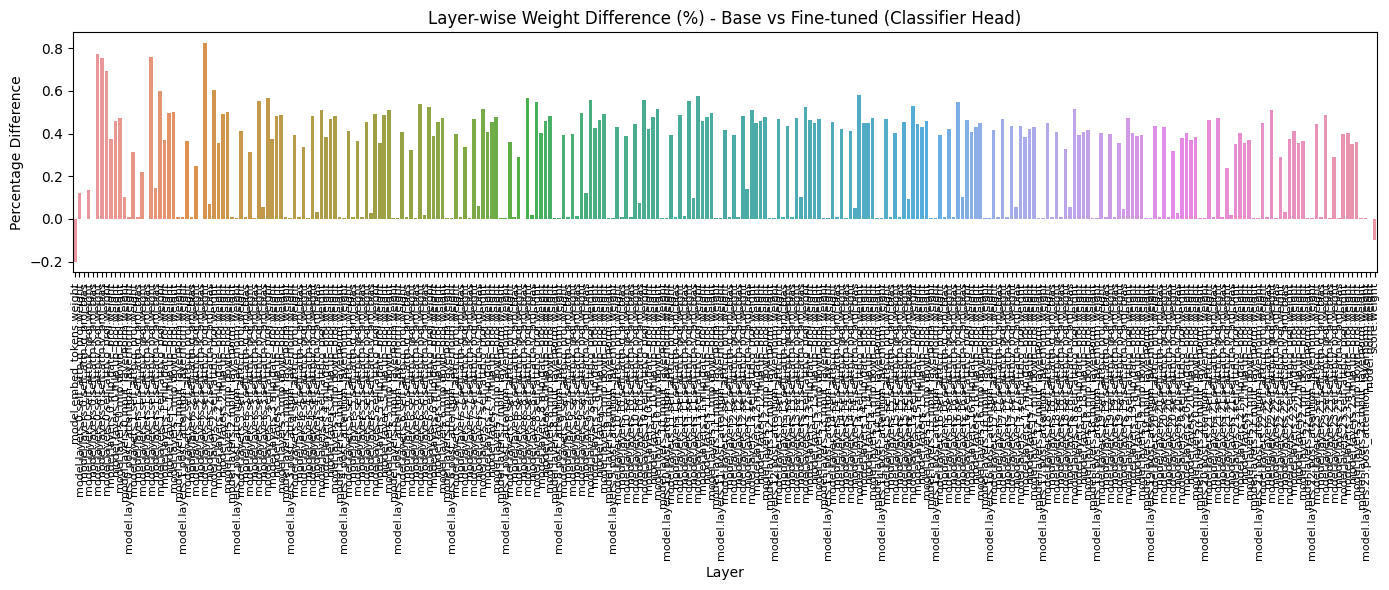

In [ ]:
base_state = base_model.state_dict()
cls_state = cls_model.state_dict()

diffs = []
layer_names = []

for name, cls_param in cls_state.items():
    base_name = name.split(".", 1)[1]  # fine tuned model has model. prefix in the state dict
    if base_name in base_state:   
        base_param = base_state[base_name]

        if base_param.shape == cls_param.shape:
            # Compute element-wise absolute diff and total magnitude
            D = torch.abs(base_param - cls_param)
            SD = D.sum().item()
            SA = torch.abs(base_param).sum().item()
            percent_diff = (SD / SA) * 100 if SA != 0 else 0.0
            diffs.append(percent_diff)
            layer_names.append(name)
        else:
            # Classifier head (new layer)
            diffs.append(-0.2)
            layer_names.append(name)
    else:
        # New layer not in base model (e.g., classifier head)
        diffs.append(-0.1)
        layer_names.append(name)

# Plotting
plt.figure(figsize=(14, 6))
sns.barplot(x=list(range(len(diffs))), y=diffs)
plt.xticks(ticks=list(range(len(layer_names))), labels=layer_names, rotation=90, fontsize=8)
plt.ylabel("Percentage Difference")
plt.xlabel("Layer")
plt.title("Layer-wise Weight Difference (%) - Base vs Fine-tuned (Classifier Head)")
plt.tight_layout()
plt.show()


all good
0
1
2
3
4


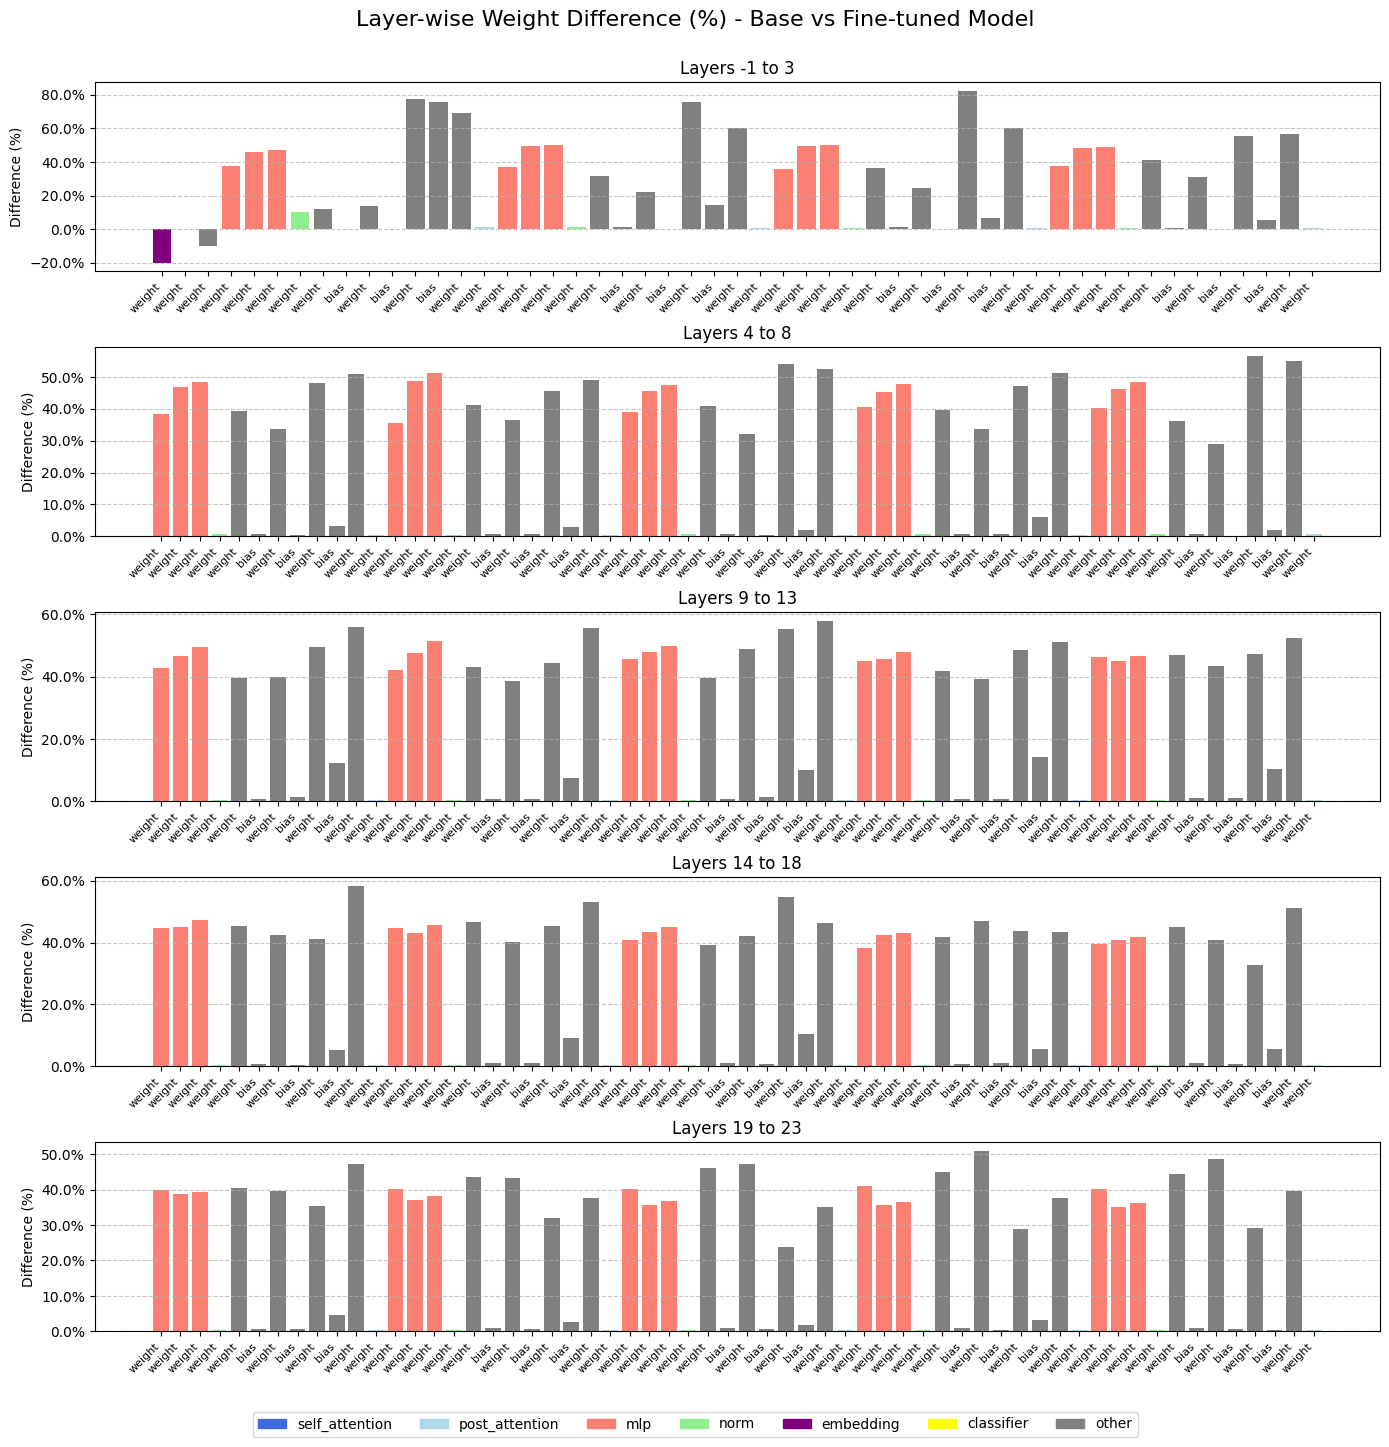

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import torch
from matplotlib.ticker import PercentFormatter

# Your existing code to calculate diffs and layer_names...
# Then use this new visualization approach:

# Extract layer numbers and types
layer_info = []
for i, name in enumerate(layer_names):
    # Try to extract layer number using regex
    layer_match = re.search(r'layers\.(\d+)', name)
    layer_num = int(layer_match.group(1)) if layer_match else -1
    
    # Determine layer type
    if "attention" in name:
        if "self_attn" in name:
            layer_type = "self_attention"
        else:
            layer_type = "post_attention"
    elif "mlp" in name:
        layer_type = "mlp"
    elif "norm" in name:
        layer_type = "norm"
    elif "embed" in name:
        layer_type = "embedding"
    elif "head" in name or "classifier" in name:
        layer_type = "classifier"
    else:
        layer_type = "other"
    
    layer_info.append((layer_num, layer_type, name, diffs[i]))

# Sort by layer number
layer_info.sort(key=lambda x: (x[0], x[1]))

# Group layers by number
layer_groups = {}
for layer_num, layer_type, name, diff in layer_info:
    if layer_num not in layer_groups:
        layer_groups[layer_num] = []
    layer_groups[layer_num].append((layer_type, name, diff))

# Create multiple subplots based on layer groups
# Let's create 5 subplots as you suggested
groups = list(layer_groups.keys())
n_groups = len(groups)
n_plots = 5  # Number of subplots
group_size = n_groups // n_plots + (1 if n_groups % n_plots > 0 else 0)

fig, axes = plt.subplots(n_plots, 1, figsize=(14, 15), sharex=False)

# Color mapping for layer types
color_map = {
    "self_attention": "royalblue",
    "post_attention": "lightblue",
    "mlp": "salmon",
    "norm": "lightgreen",
    "embedding": "purple",
    "classifier": "yellow",
    "other": "gray"
}

print("all good")

# Create subplots
for i in range(n_plots):
    print(i)
    ax = axes[i]
    start_idx = i * group_size
    end_idx = min((i + 1) * group_size, n_groups)
    
    if start_idx >= n_groups:
        ax.set_visible(False)
        continue
        
    current_groups = groups[start_idx:end_idx]
    
    # Collect data for this subplot
    plot_names = []
    plot_diffs = []
    plot_colors = []
    
    for group in current_groups:
        for layer_type, name, diff in layer_groups[group]:
            plot_names.append(name.split('.')[-1] if '.' in name else name)
            plot_diffs.append(diff)
            plot_colors.append(color_map.get(layer_type, "gray"))
    
    # Create the plot
    bars = ax.bar(range(len(plot_diffs)), plot_diffs, color=plot_colors)
    ax.set_xticks(range(len(plot_names)))
    ax.set_xticklabels(plot_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel("Difference (%)")
    ax.set_title(f"Layers {groups[start_idx]} to {groups[end_idx-1]}")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))
    
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add text annotation for layer numbers
    for j, bar in enumerate(bars):
        full_name = plot_names[j]
        # if j % 5 == 0:  # Add text every 5 bars to avoid overcrowding
        #     ax.text(j, -0.05, f"{current_groups[j//len(layer_groups[current_groups[0]])]}",
        #            ha='center', va='top', rotation=90, fontsize=6)

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
labels = list(color_map.keys())
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=len(color_map))

plt.suptitle("Layer-wise Weight Difference (%) - Base vs Fine-tuned Model", fontsize=16)
plt.tight_layout(rect=[0, 0.06, 1, 0.98])
plt.subplots_adjust(hspace=0.4)
plt.show()

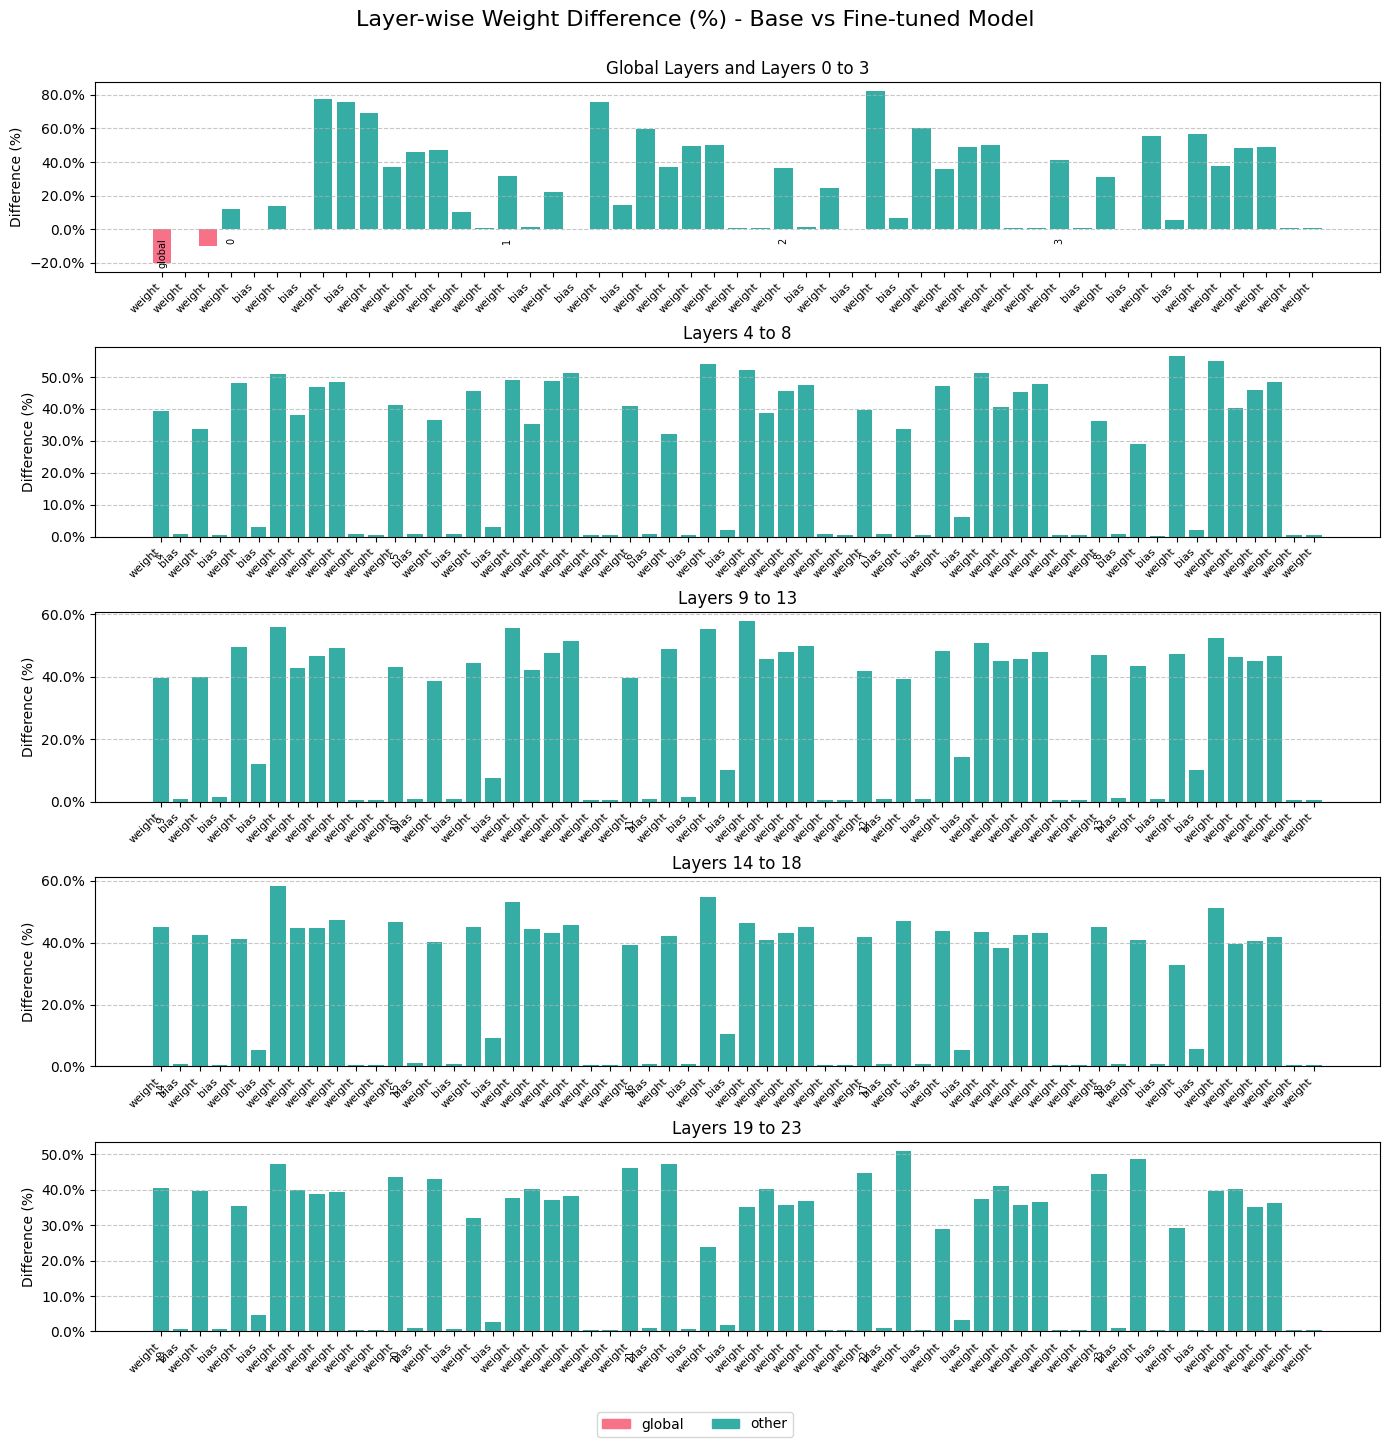

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import torch
from matplotlib.ticker import PercentFormatter

# Calculate diffs and layer_names as in your original code
# ...

# Get model information
model_info = get_model_info(cls_model)

# Create a mapping from layer name to layer type
layer_type_mapping = {}
for layer in model_info["Layers"]:
    layer_type_mapping[layer['Layer Name']] = layer['Layer Type']

# Extract layer numbers and types
layer_info = []
for i, name in enumerate(layer_names):
    # Try to extract layer number using regex
    layer_match = re.search(r'layers\.(\d+)', name)
    layer_num = int(layer_match.group(1)) if layer_match else -1
    
    # Get layer type from mapping if available, otherwise use a fallback
    if name in layer_type_mapping:
        layer_type = layer_type_mapping[name]
    else:
        # Fallback to a simplified categorization
        if "head" in name or "classifier" in name:
            layer_type = "classifier"
        elif layer_num == -1:
            layer_type = "global" 
        else:
            layer_type = "other"
    
    layer_info.append((layer_num, layer_type, name, diffs[i]))

# Sort by layer number
layer_info.sort(key=lambda x: (x[0], x[1]))

# Group layers by number
layer_groups = {}
for layer_num, layer_type, name, diff in layer_info:
    if layer_num not in layer_groups:
        layer_groups[layer_num] = []
    layer_groups[layer_num].append((layer_type, name, diff))

# Create multiple subplots based on layer groups
groups = list(layer_groups.keys())
n_groups = len(groups)
n_plots = 5  # Number of subplots
group_size = n_groups // n_plots + (1 if n_groups % n_plots > 0 else 0)

fig, axes = plt.subplots(n_plots, 1, figsize=(14, 15), sharex=False)

# Get unique layer types for color mapping
unique_types = set(layer_type for _, layer_type, _, _ in layer_info)
color_palette = sns.color_palette("husl", len(unique_types))
color_map = {layer_type: color_palette[i] for i, layer_type in enumerate(unique_types)}

# Create subplots
for i in range(n_plots):
    ax = axes[i] if n_plots > 1 else axes
    start_idx = i * group_size
    end_idx = min((i + 1) * group_size, n_groups)
    
    if start_idx >= n_groups:
        if n_plots > 1:
            ax.set_visible(False)
        continue
        
    current_groups = groups[start_idx:end_idx]
    
    # Collect data for this subplot
    plot_names = []
    plot_diffs = []
    plot_colors = []
    plot_layer_nums = []
    
    for group in current_groups:
        for layer_type, name, diff in layer_groups[group]:
            short_name = name.split('.')[-1] if '.' in name else name
            plot_names.append(short_name)
            plot_diffs.append(diff)
            plot_colors.append(color_map.get(layer_type, "gray"))
            plot_layer_nums.append(group)
    
    # Create the plot
    bars = ax.bar(range(len(plot_diffs)), plot_diffs, color=plot_colors)
    ax.set_xticks(range(len(plot_names)))
    ax.set_xticklabels(plot_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel("Difference (%)")
    
    if -1 in current_groups:
        title_text = "Global Layers and " if len(current_groups) > 1 else ""
        other_layers = [g for g in current_groups if g != -1]
        if other_layers:
            title_text += f"Layers {min(other_layers)} to {max(other_layers)}"
        else:
            title_text += "Global Layers"
    else:
        title_text = f"Layers {min(current_groups)} to {max(current_groups)}"
    
    ax.set_title(title_text)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))
    
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add text annotation for layer numbers
    last_annotated = -999
    for j, bar in enumerate(bars):
        layer_num = plot_layer_nums[j]
        if layer_num != last_annotated:
            ax.text(j, -0.05, f"{layer_num}" if layer_num != -1 else "global",
                   ha='center', va='top', rotation=90, fontsize=7)
            last_annotated = layer_num

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
labels = list(color_map.keys())
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=min(len(color_map), 4))

plt.suptitle("Layer-wise Weight Difference (%) - Base vs Fine-tuned Model", fontsize=16)
plt.tight_layout(rect=[0, 0.06, 1, 0.98])
plt.subplots_adjust(hspace=0.4)
plt.show()